In [62]:
import sqlalchemy as sa
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

database_management_sys = sa.create_engine('sqlite:///../../../../Desktop/rerun-data-no-long-run/se/main.db')
connect_dbms_to_db = database_management_sys.connect()

In [63]:
supp_en_data = pd.read_sql('folk_theorem_experiment', connect_dbms_to_db)
supp_en_data.head()

,experiment_number,number_of_players,tournament_player_set,player_strategy_name,is_long_run_time,is_stochastic,memory_depth_of_strategy,prob_of_game_ending,payoff_matrix,num_of_repetitions,num_of_equilibria,nash_equilibria,least_prob_of_defection,greatest_prob_of_defection,noise,warning_message
0,0,2,0,Inverse,False,True,Inf,0.001000,3. 0.99159429 1.03362284 1.,500,3,1. 0. 1. 0. ...,0.0,1.0,0.0,None
1,0,2,0,Defector,False,False,0,0.001000,3. 0.99159429 1.03362284 1.,500,3,1. 0. 1. 0. ...,0.0,1.0,0.0,None
2,1,2,0,Inverse,False,True,Inf,0.011081,3. 0.95530245 1.1787902 1.,500,3,1. 0. 1. 0. ...,0.0,1.0,0.0,None
3,1,2,0,Defector,False,False,0,0.011081,3. 0.95530245 1.1787902 1.,500,3,1. 0. 1. 0. ...,0.0,1.0,0.0,None
4,2,2,0,Inverse,False,True,Inf,0.021162,3. 0.9212484 1.31500641 1.,500,3,1. 0. 1. 0. ...,0.0,1.0,0.0,None


In [64]:
len(supp_en_data)

110500

In [65]:
from pathlib import *
p = Path("../../images/folk_thm")
if p.exists() == False:
    p.mkdir(parents=True)
    print("Path ../../images/folk_thm was created.")
else:
    print("Path ../../images/folk_thm already exists.")

Path ../../images/folk_thm already exists.


In [119]:
grouped_supp_en = supp_en_data.groupby(["experiment_number"]).mean()
grouped_supp_en.head()

,number_of_players,tournament_player_set,is_long_run_time,is_stochastic,prob_of_game_ending,num_of_repetitions,num_of_equilibria,least_prob_of_defection,greatest_prob_of_defection,noise
experiment_number,,,,,,,,,,
0,2,0,0.0,0.5,0.001000,500,3,0.0,1.0,0.0
1,2,0,0.0,0.5,0.011081,500,3,0.0,1.0,0.0
2,2,0,0.0,0.5,0.021162,500,3,0.0,1.0,0.0
3,2,0,0.0,0.5,0.031242,500,3,0.0,1.0,0.0
4,2,0,0.0,0.5,0.041323,500,3,0.0,1.0,0.0


In [117]:
for num_of_players in grouped_supp_en["number_of_players"].drop_duplicates():
    p = Path("../../images/folk_thm/single_game/" + str(num_of_players) + "/")
    if p.exists() == False:
        p.mkdir(parents=True)
        print("Path ../../images/folk_thm/single_game/" + str(num_of_players) + "was created.")
    else:
        print("Path ../../images/folk_thm/single_game/" + str(num_of_players) + "already exists.")
    for noise in grouped_supp_en["noise"].drop_duplicates():
        q = p / str(noise) 
        if q.exists() == False:
            q.mkdir()
            print("Path ../../images/folk_thm/single_game/" + str(num_of_players) + "/" + str(round(noise, 1)) + "was created.")
        else:
            print("Path ../../images/folk_thm/single_game/" + str(num_of_players) + "/" + str(round(noise, 1)) + "already exists.")

Path ../../images/folk_thm/single_game/2already exists.
Path ../../images/folk_thm/single_game/2/0.0already exists.
Path ../../images/folk_thm/single_game/2/0.1already exists.
Path ../../images/folk_thm/single_game/2/0.2already exists.
Path ../../images/folk_thm/single_game/2/0.3already exists.
Path ../../images/folk_thm/single_game/2/0.4already exists.
Path ../../images/folk_thm/single_game/2/0.5already exists.
Path ../../images/folk_thm/single_game/2/0.6already exists.
Path ../../images/folk_thm/single_game/2/0.7already exists.
Path ../../images/folk_thm/single_game/2/0.8already exists.
Path ../../images/folk_thm/single_game/2/0.9already exists.
Path ../../images/folk_thm/single_game/2/1.0already exists.
Path ../../images/folk_thm/single_game/2/0.1already exists.
Path ../../images/folk_thm/single_game/2/0.2already exists.
Path ../../images/folk_thm/single_game/2/0.4already exists.
Path ../../images/folk_thm/single_game/2/0.8already exists.
Path ../../images/folk_thm/single_game/3alre

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\sophi\\Documents\\final-project\\src\\analysing-the-data\\Foo\\4\\file.xlsx'

In [67]:
two_player_supp_en = grouped_supp_en[grouped_supp_en["number_of_players"] == 2]
two_player_supp_en_no_noise = two_player_supp_en[two_player_supp_en["noise"] == 0]
two_player_supp_en_no_noise.head()

,number_of_players,tournament_player_set,is_long_run_time,is_stochastic,prob_of_game_ending,num_of_repetitions,num_of_equilibria,least_prob_of_defection,greatest_prob_of_defection,noise
experiment_number,,,,,,,,,,
0,2,0,0.0,0.5,0.001000,500,3,0.0,1.0,0.0
1,2,0,0.0,0.5,0.011081,500,3,0.0,1.0,0.0
2,2,0,0.0,0.5,0.021162,500,3,0.0,1.0,0.0
3,2,0,0.0,0.5,0.031242,500,3,0.0,1.0,0.0
4,2,0,0.0,0.5,0.041323,500,3,0.0,1.0,0.0


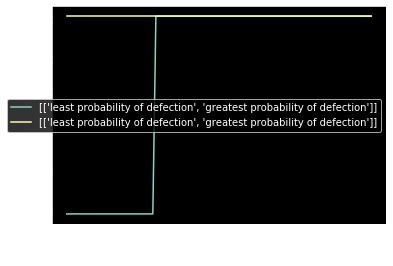

In [69]:
graph1 = plt.figure()
plt.xlabel("$p =$ the probability of the game ending" )
plt.ylabel("probability of defection in equilibria")
plt.title("")
plt.plot(two_player_supp_en_no_noise[two_player_supp_en_no_noise["tournament_player_set"]==0]["prob_of_game_ending"], two_player_supp_en_no_noise[two_player_supp_en_no_noise["tournament_player_set"]==0][["least_prob_of_defection", "greatest_prob_of_defection"]], label=[["least probability of defection", "greatest probability of defection"]])
plt.legend()
plt.show()

In [21]:
two_player_zero_noise = """
    SELECT prob_of_game_ending, least_prob_of_defection, greatest_prob_of_defection
    FROM folk_theorem_experiment
    WHERE number_of_players = '2'
    AND player_strategy_name = 'Defector'
    AND noise = '0'
    AND warning_message = 'None'
"""
two_player_zero_noise_data = pd.read_sql(two_player_zero_noise, connect_dbms_to_db)

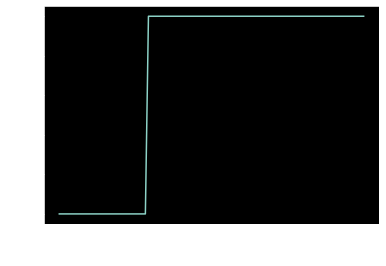

In [22]:
graph1 = plt.figure()
plt.xlabel("$p =$ the probability of the game ending" )
plt.ylabel("probability of defection in equilibria")
plt.title("")
plt.plot(two_player_zero_noise_data.loc[0:99, 'prob_of_game_ending'], two_player_zero_noise_data.loc[0:99, 'least_prob_of_defection'])
plt.show()

In [ ]:
graph1 = plt.figure()
plt.xlabel("$p =$ the probability of the game ending" )
plt.ylabel("probability of defection in equilibria")
plt.title("")
plt.plot(two_player_zero_noise_data.loc[0:100, 'prob_of_game_ending'], two_player_zero_noise_data.loc[0:100, 'least_prob_of_defection'])
plt.show()

In [7]:
dbms = sa.create_engine('sqlite:///../Database-code/data/vertex_enumeration/main.db')
connect_to_db = database_management_sys.connect()

In [8]:
vertex_en_data = pd.read_sql('folk_theorem_experiment', connect_to_db)

In [9]:
vertex_en_data.head()

,experiment_number,player_strategy_name,is_long_run_time,is_stochastic,memory_depth_of_strategy,prob_of_game_ending,payoff_matrix,num_of_repetitions,num_of_equilibria,nash_equilibria,least_prob_of_defection,greatest_prob_of_defection,noise,could_be_degenerate
0,1,Adaptive Pavlov 2011,False,False,Inf,0.0010,3. 0.98358155 1.0656738 1.,10,3.0,1. 0. 1. 0. 0. ...,0.0,1.0,0.0,False
1,1,Defector,False,False,0,0.0010,3. 0.98358155 1.0656738 1.,10,3.0,1. 0. 1. 0. 0. ...,0.0,1.0,0.0,False
2,2,Adaptive Pavlov 2011,False,False,Inf,0.2505,3. 0.7347619 2.06095238 1.,10,3.0,1. 0. 1. 0. 0....,0.0,1.0,0.0,False
3,2,Defector,False,False,0,0.2505,3. 0.7347619 2.06095238 1.,10,3.0,1. 0. 1. 0. 0....,0.0,1.0,0.0,False
4,3,Adaptive Pavlov 2011,False,False,Inf,0.5000,3. 0.3 3.8 1.,10,1.0,0. 1. 0. 1.,1.0,1.0,0.0,False
